# PnP-Flow demo

In [4]:
from PIL import Image
import torch
import torchvision.transforms as v2
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.models import UNet
from IPython.display import display, clear_output


### Load pre-trained model on celeba 

In [ ]:
!pip install gdown
!gdown --id 1ZZ6S-PGRx-tOPkr4Gt3A6RN-PChabnD6

In [ ]:
model = UNet(input_channels=3,
                     input_height=128,
                     ch=32,
                     ch_mult=(1, 2, 4, 8),
                     num_res_blocks=6,
                     attn_resolutions=(16, 8),
                     resamp_with_conv=True,
                     )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('model_final_celeba.pt', map_location=device))
model.to(device)
model.eval()

## Load test image and inpaint it

In [6]:
image_path = 'example.jpg'
clean_img = Image.open(image_path)

# Define the transformation
transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply the transformation
clean_img = transform(clean_img).unsqueeze(0).to(device)


In [7]:
# Create a random mask with 70% missing pixels
mask = np.random.rand(128, 128) > 0.7
mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

# define the linear operator H
def H(x):
    return x * mask_tensor

# Apply the mask to the image tensor and add noise
sigma_noise = 0.001
noisy_img = H(clean_img) + sigma_noise * torch.randn_like(clean_img)

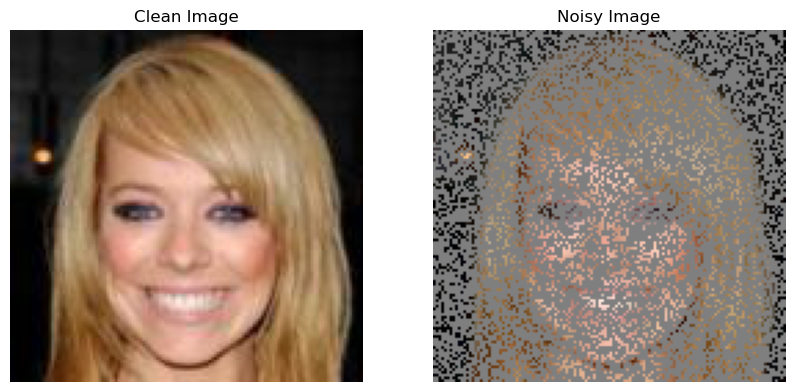

In [8]:
# plot the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(torch.clip((clean_img[0].cpu() + 1) / 2, 0, 1).permute(1, 2, 0))
plt.axis('off')
plt.title('Clean Image')
plt.subplot(1, 2, 2)
plt.imshow(torch.clip((noisy_img[0].cpu() + 1) / 2, 0, 1).permute(1, 2, 0), vmin=0, vmax=1)
plt.axis('off')
plt.title('Noisy Image')
plt.show()

## Restore it with PnP-flow

### Define denoiser

In [9]:
def denoiser(x, t):
        return x + (1 - t.view(-1, 1, 1, 1)) * model(x, t)

### Run PnP-Flow

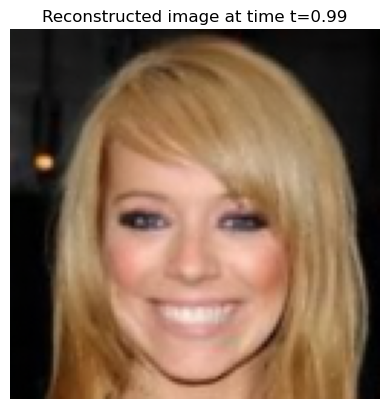

In [10]:
N = 100 # Number of time steps
alpha = 0.01 # Exponent in the learning rate
delta = 1 / N # Time step size
x = torch.zeros((1, 3, 128, 128)).to(device)
fig, ax = plt.subplots()

for i in range(N):
    
    with torch.no_grad():

        t = torch.ones(len(x), device=device) * delta * i

        # Gradient step on the data-fidelity term
        lr_t = (1 - t)**alpha
        z = x - lr_t * H(H(x) - noisy_img) # H is symmetric

        # Interpolation step       
        z_tilde = t.view(-1, 1, 1, 1) * z + torch.randn_like(x) * (1 - t.view(-1, 1, 1, 1))
    
        # Denoising step
        x_new = denoiser(z_tilde, t)

        # Update the solution
        x = x_new.clone()
        
        # Plot the current image
        if i % 5 == 0 or i == N - 1:
            clear_output(wait=True)
            ax.imshow(torch.clip((x[0].cpu() + 1) / 2, 0, 1).permute(1, 2, 0), vmin=0, vmax=1)
            ax.axis('off')
            ax.set_title('Reconstructed image at time t={:4.2f}'.format(delta * i))
            display(fig)
            
clear_output(wait=False)